In [12]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import MaxPooling2D

import tensorflow.keras.backend as K
import tensorflow as tf

import cv2
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import random
import os
import tensorflow as tf
import keras as keras
from PIL import Image
import warnings
warnings.filterwarnings('ignore')
import src.proprietary_functions as src

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Lambda
from tensorflow.keras.datasets import mnist

In [13]:
image_file = './sample_data/Img/'
annotation_file = './sample_data/Anno/'
export_file = './export'

identity_file = annotation_file + 'identity_CelebA.txt'
bbox_file = annotation_file + 'list_bbox_celeba.txt'

# Train/test split variables
random_seed = 123
test_size = 0.2
validation_size = 0.2


image_id_col = 'image_id'
bbox_col_names = {
    'x_start' : 'x_1',
    'y_start' : 'y_1',
    'width' : 'width',
    'height' : 'height',
    'x_end' : '',
    'y_end' : ''}

identity_file = annotation_file + 'identity_CelebA.txt'
bbox_file = annotation_file + 'list_bbox_celeba.txt'



# Loading dataset metadata
identity = pd.read_csv(identity_file, sep=" ", header = None,names=['image', 'image_id'])
bbox = pd.read_csv(bbox_file, delim_whitespace=True)


#%% Filtering faces that appear at least 20 times
labels_annot = pd.DataFrame(identity.image_id.value_counts(ascending=True)).query('image_id > 20').index.tolist()
identity_filtered = identity[identity['image_id'].isin(labels_annot)]

#%% [SPRINT 2] Train/test split of the annotations
imgs = identity_filtered['image']
labels = identity_filtered['image_id']

temp_imgs, test_imgs, _, test_labels = train_test_split(imgs, labels,
                                               test_size = test_size,
                                               random_state = random_seed,        
                                               stratify = labels)
train_imgs, valid_imgs, train_labels, valid_labels = train_test_split(temp_imgs, _,
                                               test_size = validation_size/(1-test_size),
                                               random_state = random_seed,        
                                               stratify = _)

#%% 
# Safe train/test split

if not os.path.exists(export_file):
    os.makedirs(export_file)

if not os.path.exists(export_file + '/setting'):
    os.makedirs(export_file + '/setting')

if export_file != '':
    train_imgs.to_csv(export_file + '/setting/train_imgs.csv', index = False)
    valid_imgs.to_csv(export_file + '/setting/valid_imgs.csv', index = False)
    test_imgs.to_csv(export_file + '/setting/test_imgs.csv', index = False)

<h1><b>CONTRASTIVE LOSS MODEL<h1>

In [14]:
#Filtering training set - both images and labels as data frame.
training_set = identity_filtered[identity_filtered['image'].isin(train_imgs)]

In [15]:
#Extracting 100 labels having the most pictures - we gonna use only part of the training set.
labs = list(train_labels.value_counts().head(1000).index)

In [16]:
#extracting randomly 6 pictures per each label.
random.seed(12496)
pics = {i:[random.choices(list(training_set.loc[training_set['image_id'] == i,'image']), k = 10)] for i in labs}

In [17]:
#combining both filtered pictures and labels into a data frame.
subset_df = pd.DataFrame(pics).transpose()
subset_df.index = labs
subset_df.columns = ['pics']
subset_df[[f'pic_{i}' for i  in range(1,11)]] = pd.DataFrame(subset_df.pics.tolist(), index= subset_df.index)
subset_df = subset_df.drop('pics',axis = 1)
subset_df = subset_df.stack().reset_index().drop('level_1', axis=1).rename(columns = {'level_0':'label', 0: 'image'})
subset_df

,label,image
0,2820,001553.jpg
1,2820,003568.jpg
2,2820,008286.jpg
3,2820,034769.jpg
4,2820,043941.jpg
...,...,...
9995,7233,009730.jpg
9996,7233,093995.jpg
9997,7233,118662.jpg
9998,7233,019452.jpg


In [18]:
#Extracting the filtered labels and pictures.
imgs_pn, labels_pn = subset_df['image'], subset_df['label']

In [19]:
#From the filtered subset of training set, we split this subset into training, validation and test set.
temp_X, test_X, temp_Y, test_Y = train_test_split(imgs_pn, labels_pn,
                    test_size = 0.2,random_state = random_seed, stratify = labels_pn)

train_X, valid_X, train_Y, valid_Y = train_test_split(temp_X, temp_Y,
                    test_size = 0.25,random_state = random_seed, stratify = temp_Y)

In [20]:
#Creating paths for saving cropped images from the filtered subsets.
if not os.path.exists('./cropped/train/'):
    os.makedirs('./cropped/train/')

if not os.path.exists('./cropped/valid/'):
    os.makedirs('./cropped/valid/')

if not os.path.exists('./cropped/test/'):
    os.makedirs('./cropped/test/')

In [21]:
def cropping(imgs, bboxes, sample):
    
    def face_crop(image_name, bbox_df):
        # Loading Image
        image_path = './data/Img/img_celeba/' + image_name
        img = cv2.imread(image_path)

    # Setting bounding box coordinates
        startX = bbox_df[bbox_df['image_id'] == image_name]['x_1'].values[0]
        startY = bbox_df[bbox_df['image_id'] == image_name]['y_1'].values[0]
        endX = startX + bbox_df[bbox_df['image_id'] == image_name]['width'].values[0]
        endY = startY + bbox_df[bbox_df['image_id'] == image_name]['height'].values[0]
    
    #Cropping and saving boounding box
        crop_img = img[startY:endY, startX:endX]
        output_img = crop_img

        output_img = cv2.resize(crop_img, (224, 224))

        return output_img

    cropped_pics = []
    pic_names = []

    for pic in imgs:
        crop_img = face_crop(pic, bboxes)
        cropped_pics.append(crop_img)
        pic_names.append(pic)

        cv2.imwrite(f'./cropped/{sample.lower()}/{pic}', crop_img)

    return cropped_pics, pic_names
        

In [22]:
cropped_train_X, train_X_names = cropping(train_X, bbox, 'train')
cropped_valid_X, valid_X_names = cropping(valid_X, bbox, 'valid')
cropped_test_X, test_X_names = cropping(test_X, bbox, 'test')

In [11]:
if not os.path.exists('./cropped_numpys/'):
    os.makedirs('./cropped_numpys/')

In [ ]:
print('Number of training instances:',len(cropped_train_X))
print('Number of validation instances:',len(cropped_valid_X))
print('Number of test instances:',len(cropped_test_X))

Number of training instances: 6000
Number of validation instances: 2000
Number of test instances: 2000


In [23]:
#converting list of images into arrays
arr_train_X = np.array(cropped_train_X)
arr_valid_X = np.array(cropped_valid_X)
arr_test_X = np.array(cropped_test_X)

In [28]:
for npy ,sample in zip([arr_train_X, arr_valid_X, arr_test_X],  ['train','valid','test']):
    with open(f'./cropped_numpys/cropped_{sample}_X.npy', 'wb') as f:
        np.save(f, npy)

In [39]:
for lst ,sample in zip([train_X_names, valid_X_names, test_X_names],  ['train','valid','test']):
    with open(f'./cropped_numpys/cropped_{sample}_X_names.npy', 'wb') as f:
        np.save(f, np.array(lst))

In [44]:
#converting list of labels into arrays
arr_train_Y = np.array(train_Y)
arr_valid_Y= np.array(valid_Y)
arr_test_Y = np.array(test_Y)

In [45]:
for lab ,sample in zip([arr_train_Y, arr_valid_Y, arr_test_Y],  ['train','valid','test']):
    with open(f'./cropped_numpys/cropped_{sample}_Y.npy', 'wb') as f:
        np.save(f, lab)

#add a channel dimension to the images
trainX = np.expand_dims(arr_train_X, axis=-1)
validX = np.expand_dims(arr_valid_X, axis =-1)
testX = np.expand_dims(arr_test_X, axis=-1)

In [64]:
dict_idx

{14: array([ 901, 1280, 1776, 2458, 3844, 4375], dtype=int64),
 17: array([ 289, 1590, 1735, 2353, 4279, 4540], dtype=int64),
 38: array([ 379,  921, 1789, 2558, 4666, 5382], dtype=int64),
 59: array([ 797,  932, 2160, 2310, 3564, 4084], dtype=int64),
 78: array([1073, 2410, 2588, 2692, 4274, 5544], dtype=int64),
 85: array([ 227, 1663, 1986, 3263, 3333, 3585], dtype=int64),
 95: array([ 427, 1884, 2149, 3100, 4480, 4624], dtype=int64),
 209: array([ 381, 3302, 4095, 4993, 5424, 5504], dtype=int64),
 234: array([ 117,  937, 3409, 3432, 5250, 5972], dtype=int64),
 273: array([  82, 1174, 2418, 3130, 4791, 5240], dtype=int64),
 284: array([2527, 2951, 2998, 3366, 5629, 5813], dtype=int64),
 291: array([ 150,  878, 1538, 3238, 5243, 5441], dtype=int64),
 295: array([ 335,  622, 2566, 3003, 3740, 5974], dtype=int64),
 301: array([1178, 1423, 4314, 4726, 5443, 5524], dtype=int64),
 303: array([1672, 2637, 3690, 3851, 4045, 4778], dtype=int64),
 305: array([ 162,  970, 1606, 2530, 4550, 5467

In [87]:
uniqueClasses = np.unique(arr_train_Y)
dict_idx = {i:np.where(arr_train_Y == i)[0] for i in uniqueClasses}
currentImage = arr_train_X[0]
label = arr_train_Y[0]
image_name = train_X_names[0]

idxB = np.random.choice(dict_idx[label])
posImage = arr_train_X[idxB]
posImage_name = train_X_names[idxB]

negLab = np.random.choice([i for i in dict_idx.keys() if i != label])
negIdx = np.random.choice(dict_idx[negLab])
negImage = arr_train_X[negIdx]
negImage_name = train_X_names[negIdx]


In [88]:
label

4147

In [89]:
idxB

5675

In [90]:
dict_idx[label]

array([   0,  859, 2497, 2987, 5675, 5871], dtype=int64)

In [91]:
arr_train_Y[idxB]

4147

In [92]:
train_X_names[idxB]

'168950.jpg'

In [93]:
cv2.imread('./data/Img/mg_celeba/'+'180459.jpg')

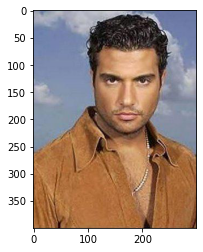

In [94]:
plt.imshow(cv2.cvtColor(cv2.imread('./data/Img/Img_celeba/'+posImage_name), cv2.COLOR_BGR2RGB))

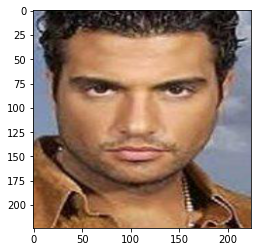

In [95]:
plt.imshow(cv2.cvtColor(posImage, cv2.COLOR_BGR2RGB))

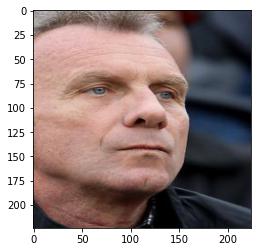

In [84]:
plt.imshow(cv2.cvtColor(negImage, cv2.COLOR_BGR2RGB))

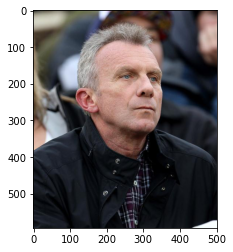

In [85]:
plt.imshow(cv2.cvtColor(cv2.imread('./data/Img/Img_celeba/'+negImage_name), cv2.COLOR_BGR2RGB))

In [96]:
#function creating pairs
def	make_pairs(images, labels, image_names):

	pairImages = []
	pairLabels = []
	pairImagesNames = []
	uniqueClasses = np.unique(labels)

	dict_idx = {i:np.where(labels == i)[0] for i in uniqueClasses}

	for idxA in range(len(images)):
		currentImage = images[idxA]
		label = labels[idxA]
		currentImage_name = image_names[idxA]

		#positive pair
		idxB = np.random.choice(dict_idx[label])
		posImage = images[idxB]
		posImage_name = image_names[idxB]
		pairImages.append([currentImage, posImage])
		pairImagesNames.append([currentImage_name, posImage_name])
		pairLabels.append([1])

		#negative pair
		negLab = np.random.choice([i for i in dict_idx.keys() if i != label])
		negIdx = np.random.choice(dict_idx[negLab])
		negImage = images[negIdx]
		negImage_name = image_names[negIdx]
		pairImages.append([currentImage, negImage])
		pairImagesNames.append([currentImage_name, negImage_name])
		pairLabels.append([0])

	return (np.array(pairImages),np.array(pairLabels)), np.array(pairImagesNames)

In [98]:
(pairTrain, labelTrain), pairNamesTrain = make_pairs(arr_train_X, arr_train_Y, train_X_names)
(pairValid, labelValid), pairNamesValid = make_pairs(arr_valid_X, arr_valid_Y, valid_X_names)
(pairTest, labelTest), pairNamesTest = make_pairs(arr_test_X, arr_test_Y, test_X_names)

In [100]:
dict_pairs = {'train': {'pair_imgs': pairTrain, 'pair_imgs_names':pairNamesTrain,'labels':labelTrain},
                'valid': {'pair_imgs': pairValid,'pair_imgs_names':pairNamesValid,'labels':labelValid},
                'test': {'pair_imgs': pairTest, 'pair_imgs_names':pairNamesTest,'labels':labelTest}}

In [108]:
for sampl in dict_pairs.keys():
    for n in dict_pairs[sampl].keys():
       with open(f'./pair_numpys/{sampl}_{n}.npy', 'wb') as f:
            np.save(f, dict_pairs[sampl][n])

In [58]:
def euclidean_distance(vectors):
	# unpack the vectors into separate lists
	(featsA, featsB) = vectors
    
	# compute the sum of squared distances between the vectors
	sumSquared = K.sum(K.square(featsA - featsB), axis=1,
		keepdims=True)

	# return the euclidean distance between the vectors
	return K.sqrt(K.maximum(sumSquared, K.epsilon()))

In [59]:
imgA = Input(shape=(224, 224, 3))
imgB = Input(shape=(224, 224, 3))

In [60]:
def build_siamese_model(inputShape, embeddingDim=48):
	# specify the inputs for the feature extractor network
	inputs = Input(inputShape)

	# define the first set of CONV => RELU => POOL => DROPOUT layers
	x = Conv2D(64, (2, 2), padding="same", activation="relu")(inputs)
	x = MaxPooling2D(pool_size=(2, 2))(x)

	# second set of CONV => RELU => POOL => DROPOUT layers
	x = Conv2D(64, (2, 2), padding="same", activation="relu")(x)
	x = MaxPooling2D(pool_size=2)(x)

    # prepare the final outputs
	pooledOutput = GlobalAveragePooling2D()(x)
	outputs = Dense(embeddingDim)(pooledOutput)
	
	# build the model
	model = Model(inputs, outputs)
	
	# return the model to the calling function
	return model

In [64]:
def contrastive_loss(y, preds, margin=1):
	# explicitly cast the true class label data type to the predicted
	# class label data type (otherwise we run the risk of having two
	# separate data types, causing TensorFlow to error out)
	y = tf.cast(y, preds.dtype)

	# calculate the contrastive loss between the true labels and
	# the predicted labels
	squaredPreds = K.square(preds)
	squaredMargin = K.square(K.maximum(margin - preds, 0))
	loss = K.mean(y * squaredPreds + (1 - y) * squaredMargin)

	# return the computed contrastive loss to the calling function
	return loss

In [61]:
featureExtractor = build_siamese_model((224, 224, 3))

In [62]:
featsA = featureExtractor(imgA)
featsB = featureExtractor(imgB)

In [63]:
distance = Lambda(euclidean_distance)([featsA, featsB])

In [65]:
model = Model(inputs=[imgA, imgB], outputs=distance)

In [66]:
model.compile(loss=contrastive_loss, optimizer="adam", metrics=["accuracy"])

In [67]:
history = model.fit(
	[pairTrain[:, 0], pairTrain[:, 1]], labelTrain[:],
	validation_data=([pairValid[:, 0], pairValid[:, 1]], labelValid[:]),
	epochs=10)

Epoch 1/10
30/30 [==============================] - 63s 2s/step - loss: 104.4655 - accuracy: 0.3802 - val_loss: 0.4967 - val_accuracy: 0.0542
Epoch 2/10
30/30 [==============================] - 59s 2s/step - loss: 0.9011 - accuracy: 0.4000 - val_loss: 0.1593 - val_accuracy: 0.3083
Epoch 3/10
30/30 [==============================] - 62s 2s/step - loss: 0.2760 - accuracy: 0.4531 - val_loss: 0.1699 - val_accuracy: 0.3333
Epoch 4/10
30/30 [==============================] - 54s 2s/step - loss: 0.2651 - accuracy: 0.4500 - val_loss: 0.1688 - val_accuracy: 0.3333
Epoch 5/10
30/30 [==============================] - 57s 2s/step - loss: 0.2603 - accuracy: 0.4437 - val_loss: 0.1615 - val_accuracy: 0.3208
Epoch 6/10
30/30 [==============================] - 59s 2s/step - loss: 0.2574 - accuracy: 0.4427 - val_loss: 0.1600 - val_accuracy: 0.3208
Epoch 7/10
30/30 [==============================] - 56s 2s/step - loss: 0.2557 - accuracy: 0.4458 - val_loss: 0.1572 - val_accuracy: 0.3125
Epoch 8/10
30/30 [

In [72]:
#Viktor's notebook
def initialize_base_network():
    input = Input(shape=(224,224,3))
    x = Flatten()(input)
    x = Dense(128, activation='relu')(x)
    x = Dense(128, activation='relu')(x)
    return Model(inputs=input, outputs=x)

base_network = initialize_base_network()

# create the left input and point to the base network
input_a = Input(shape=(224,224,3), name="left_input")
vect_output_a = base_network(input_a)

# create the right input and point to the base network
input_b = Input(shape=(224,224,3), name="right_input")
vect_output_b = base_network(input_b)

# measure the similarity of the two vector outputs
output = Lambda(euclidean_distance, name="output_layer")([vect_output_a, vect_output_b])
# specify the inputs and output of the model
model_2 = Model([input_a, input_b], output)

model_2.compile(loss=contrastive_loss, optimizer='adam', metrics=["accuracy"])
history_2 = model_2.fit([pairTrain[:, 0], pairTrain[:, 1]], labelTrain[:],verbose=1, validation_data=([pairValid[:, 0], pairValid[:, 1]], labelValid[:]), epochs=10)

Epoch 1/10
30/30 [==============================] - 10s 237ms/step - loss: 2905043.7500 - accuracy: 0.4615 - val_loss: 0.4997 - val_accuracy: 0.5000
Epoch 2/10
30/30 [==============================] - 6s 205ms/step - loss: 0.4997 - accuracy: 0.5000 - val_loss: 0.4997 - val_accuracy: 0.5000
Epoch 3/10
30/30 [==============================] - 5s 153ms/step - loss: 0.4997 - accuracy: 0.5000 - val_loss: 0.4997 - val_accuracy: 0.5000
Epoch 4/10
30/30 [==============================] - 5s 154ms/step - loss: 0.4997 - accuracy: 0.5000 - val_loss: 0.4997 - val_accuracy: 0.5000
Epoch 5/10
30/30 [==============================] - 5s 153ms/step - loss: 0.4997 - accuracy: 0.5000 - val_loss: 0.4997 - val_accuracy: 0.5000
Epoch 6/10
30/30 [==============================] - 5s 152ms/step - loss: 0.4997 - accuracy: 0.5000 - val_loss: 0.4997 - val_accuracy: 0.5000
Epoch 7/10
30/30 [==============================] - 5s 154ms/step - loss: 0.4997 - accuracy: 0.5000 - val_loss: 0.4997 - val_accuracy: 0.5000

In [83]:
def plot_training(H):
	# construct a plot that plots and saves the training history
	plt.style.use("ggplot")
	plt.figure()

	plt.plot(H.history["accuracy"], label="train_acc")
	plt.plot(H.history["val_accuracy"], label="val_acc")
	plt.title("Training Accuracy")
	plt.xlabel("Epoch #")
	plt.ylabel("Accuracy")
	plt.legend()
	plt.show()


	plt.plot(H.history["loss"], label="train_loss")
	plt.plot(H.history["val_loss"], label="val_loss")
	plt.title("Training Loss")
	plt.xlabel("Epoch #")
	plt.ylabel("Loss")
	plt.legend()
	plt.show()

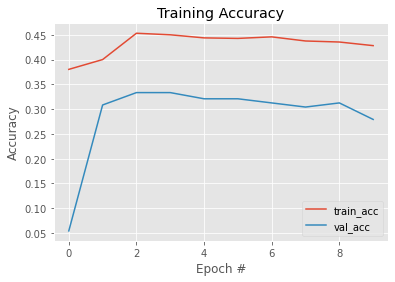

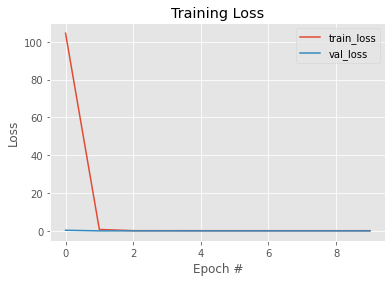

In [84]:
plot_training(history)

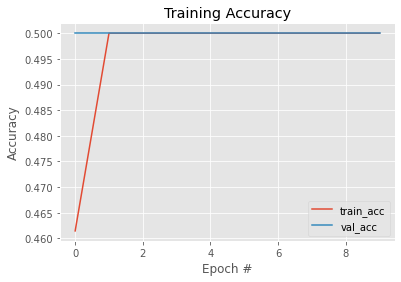

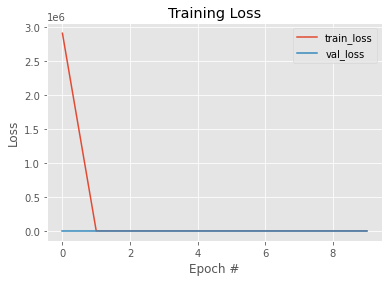

In [85]:
plot_training(history_2)

_TBD_

<h1><b>TRIPLET LOSS MODEL<b><h1>